In [561]:
results = []

In [562]:
import pandas as pd
import numpy as np
import mltools as ml
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler

X_data = pd.read_csv('data/X_train.txt')
Y_data = pd.read_csv('data/Y_train.txt')


'''scaler = MinMaxScaler()
scaler.fit(X_data)
scaler.transform(X_data)'''

# #apply SelectKBest class to extract top 10 best features
X = X_data.iloc[:,:41]
Y = Y_data.iloc[:,-1]


bestfeatures = SelectKBest(score_func=f_classif, k="all" )
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfscores],axis=1)

featureScores.columns = ['Score']  #naming the dataframe columns
df = featureScores.nlargest(3,'Score')
print("Features ordered by Score: ")
top_features = []
for index, row in df.iterrows():
    top_features.append(index)
    print(index, row['Score'])


Features ordered by Score: 
24 72.30120144068337
7 47.62128875146852
28 45.766219285324986


1 0.4033670033670034
2 0.3939393939393939
5 0.38047138047138046
10 0.3744107744107744
50 0.3811447811447811
100 0.37643097643097645
200 0.3925925925925926
Training and validation error as a function of K:


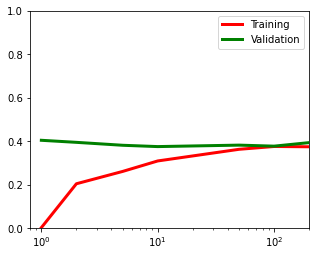

In [563]:
import numpy as np
np.random.seed(0)
import mltools as ml
import matplotlib.pyplot as plt 

X = np.genfromtxt('data/X_train.txt', delimiter=',')
Y = np.genfromtxt('data/Y_train.txt', delimiter=',')
Xa = []
for a in top_features:
    Xa.append(X[:,a])


X,Y=ml.shuffleData(X,Y)
X,_=ml.transforms.rescale(X)
Xtr,Xva,Ytr,Yva=ml.splitData(X,Y,.80)
Xtra = []
Xvaa = []
for a in top_features:
    Xtra.append(Xtr[:,a])
    Xvaa.append(Xva[:,a])

    
Xtra = np.asarray(Xtra).T
Xvaa = np.asarray(Xvaa).T

knn = ml.knn.knnClassify(Xtra,Ytr)
k_values = [1,2,5,10,50,100,200]


fig,ax=plt.subplots(1,1,figsize=(5,4))

errTr=np.zeros(len(k_values))
errVa=np.zeros(errTr.shape[0])
# print(Xtra)
for i,k in enumerate(k_values):
    
    knn.train(Xtra,Ytr,K=k)
    YvaHat = knn.predict(Xvaa)

    errTr[i]=knn.err(Xtra,Ytr)
    errVa[i]=knn.err(Xvaa,Yva)
    print(k, knn.err(Xvaa,Yva))
    
ax.semilogx(k_values,errTr,'r-',lw=3,label='Training')
ax.semilogx(k_values,errVa,'g-',lw=3,label='Validation')
ax.legend()
ax.set_xlim(.8,200)
ax.set_ylim(0,1)
print("Training and validation error as a function of K:")
plt.show()



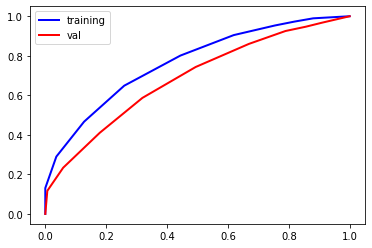

AUC training Area: 0.7702
AUC val Area: 0.6821


In [566]:
learner = ml.knn.knnClassify(Xtra,Ytr) # train a model using training data X,Y
learner.train(Xtra,Ytr,K=10)
fpr, tpr, tnr = learner.roc(Xtra, Ytr) #apply ROC on training data
fpr2, tpr2, tnr2 = learner.roc(Xvaa, Yva) #apply ROC on validation data
plt.plot(fpr, tpr, 'b-', label = "training", linewidth = 2) #plot training 
plt.plot(fpr2, tpr2, 'r-', label = "val", linewidth = 2) #plot validation
plt.legend(fontsize=10, loc=0)
plt.show()


print('AUC training Area: %0.4f' %(learner.auc(Xtra, Ytr)))
print('AUC val Area: %0.4f' %(learner.auc(Xvaa, Yva)))


Xte = np.genfromtxt('data/X_test.txt', delimiter=',')
Xtea = []

for a in top_features:
    Xtea.append(Xte[:,a])
Xtea = np.asarray(Xtea).T
results.append(learner.predict(Xtea))
# print(learner.predict(Xtea))
# Yte =np.vstack((np.arange(Xtea.shape[0]), learner.predict(Xtea))).T 
# Output a file with two columns, a row ID and a confidence in class 1: 

# np.savetxt('Y_project_submit.txt',Yte,'%d, %.2f',header='Id,Predicted',comments='',delimiter=',')


## Random Forests

In [183]:
df = featureScores.nlargest(30,'Score')
print("Features ordered by Score: ")
top_features = []
for index, row in df.iterrows():
    top_features.append(index)
    print(index, row['Score'])

Features ordered by Score: 
24 72.30120144068337
7 47.62128875146852
28 45.766219285324986
36 38.2709897718737
34 35.95010458455116
9 26.71539008167097
15 15.81570899152354
1 11.402169949278782
2 5.73290423895162
31 5.076459869496011


In [567]:
X = np.genfromtxt('data/X_train.txt', delimiter=',')
Y = np.genfromtxt('data/Y_train.txt', delimiter=',')
Xa = []
for a in top_features:
    Xa.append(X[:,a])


X,Y=ml.shuffleData(X,Y)
X,_=ml.transforms.rescale(X)
Xtr,Xva,Ytr,Yva=ml.splitData(X,Y,.80)
Xtra = []
Xvaa = []
for a in top_features:
    Xtra.append(Xtr[:,a])
    Xvaa.append(Xva[:,a])

    
Xtra = np.asarray(Xtra).T
Xvaa = np.asarray(Xvaa).T

n_bags = 50
M=Xtra.shape[0]
Mv=Xvaa.shape[0]
rforest=[None]*n_bags
YtHat=np.zeros((M,n_bags))
YvHat=np.zeros((Mv,n_bags))
for l in range(n_bags):
    #print "Training {}".format(l)                
    # uncomment if you want to monitorprogress...
    Xi,Yi=ml.bootstrapData(Xtra,Ytr,M)
    # draw this member's random sample of data
    rforest[l]=ml.dtree.treeClassify()
    #   and train the model on that draw
    
    rforest[l].train(Xi,Yi,minLeaf=4,maxDepth=30,nFeatures=20)
    YtHat[:,l]=rforest[l].predict(Xtra)
    # predict on training data
    YvHat[:,l]=rforest[l].predict(Xvaa)
    # Can use predictSoft instead

for l in [1,5,10,15,25,50]:
    # Make the prediction (mean of columns 0...l-1) and score the MSE:
    # TODO: switch to error rate / AUC
    errT=(Ytr!=(YtHat[:,0:l].mean(axis=1)>.5)).mean()
    errV=(Yva!=(YvHat[:,0:l].mean(axis=1)>.5)).mean()
    print("{:02d} members: {} train, {} valid".format(l,errT,errV))

01 members: 0.2489053553384978 train, 0.3872053872053872 valid
05 members: 0.16941731222633882 train, 0.37643097643097645 valid
10 members: 0.15695520377231392 train, 0.37643097643097645 valid
15 members: 0.13270461434826542 train, 0.3542087542087542 valid
25 members: 0.11889525092623779 train, 0.35218855218855216 valid
50 members: 0.10643314247221286 train, 0.3616161616161616 valid


In [571]:
# export to file / save
Xte = np.genfromtxt('data/X_test.txt', delimiter=',')
predict_te = np.zeros( (Xte.shape[0], n_bags) )

for ct in range(n_bags):
    predict_te[:,ct] = rforest[ct].predict(Xte)
    # the combined prediction
predict_te = np.mean(predict_te, axis=1) > 0.5

results.append(predict_te)

## Neural Networks

In [687]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import mltools as ml
import numpy as np
from sklearn import preprocessing
%matplotlib inline


X_data = pd.read_csv('data/X_train.txt')
Y_data = pd.read_csv('data/Y_train.txt')
X = X_data.iloc[:,:41]
Y = Y_data.iloc[:,-1]
X_new = preprocessing.scale(X)

# X_new = SelectKBest(f_regression,k=3).fit_transform(X,Y)

Xtr,Xva,Ytr,Yva = train_test_split(X_new,Y,test_size=0.2,random_state=20)
# play around with parameters:
nn=MLPClassifier(activation="logistic",solver="sgd", alpha=.0001, hidden_layer_sizes=(200,150),random_state=1)
nn.fit(Xtr,Ytr)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200, 150), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [664]:
pred=nn.predict(Xva)
ct=0

for i in pred:
    if i == 1:
        ct += 1
        
print(ct)
print(pred)
print(len(pred))

141
[0. 0. 0. ... 0. 0. 1.]
1485


In [665]:
a=Yva.values

In [666]:
a
count=0

In [667]:
for i in range(len(pred)):
    if pred[i]==a[i]:
        count=count+1

In [668]:
count

767

In [669]:
count/len(pred)

0.5164983164983165

In [671]:
Xte = np.genfromtxt('data/X_test.txt', delimiter=',')
Xte = Xte[:,:-1]
X_te_new = preprocessing.scale(Xte)
pred=nn.predict(X_te_new)

In [672]:
print(pred)
ct=0

for i in pred:
    if i == 1:
        ct += 1
print(ct)

[0. 0. 0. ... 0. 0. 0.]
640


In [673]:
results.append(pred)

# Putting it together

In [686]:
predict_te = np.zeros((Xte.shape[0],3))

for ct in range(3):
    predict_te[:,ct] = results[ct]
predict_te = np.mean(results, axis=1) > 0.5

[ True False False]
